In [1]:
!pip install h5py

    100% |████████████████████████████████| 2.8MB 3.0MB/s ta 0:00:01
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.4 requires cython, which is not installed.
tensorflow-tensorboard 1.5.1 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorflow-tensorboard 1.5.1 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function

import numpy as np
import time
import h5py
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras import backend as K

In [3]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

In [4]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

In [5]:
# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [8]:
# this is the placeholder for the input images
input_img = model.input

In [9]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [10]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [11]:
kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Current loss value: 11.506527
Current loss value: 24.700188
Current loss value: 45.04175
Current loss value: 67.192795
Current loss value: 89.81041
Current loss value: 112.05766
Current loss value: 132.58435
Current loss value: 162.99574
Current loss value: 182.90971
Current loss value: 208.17944
Current loss value: 234.70523
Current loss value: 260.21405
Current loss value: 290.403
Current loss value: 315.51624
Current loss value: 342.0958
Current loss value: 364.91797
Current loss value: 391.21808
Current loss value: 418.86322
Current loss value: 441.72476
Current loss value: 468.8719
Filter 0 processed in 3s
Processing filter 1
Current loss value: 0.11239125
Current loss value: 6.036941
Current loss value: 28.130123
Current loss value: 58.19795
Current loss value: 88.180374
Current loss value: 119.08187
Current loss value: 145.86282
Current loss value: 187.36852
Current loss value: 226.91962

Current loss value: 404.83038
Current loss value: 434.0782
Current loss value: 460.74847
Current loss value: 482.27887
Current loss value: 508.9252
Current loss value: 530.22
Current loss value: 557.5984
Current loss value: 577.03894
Current loss value: 602.91846
Filter 13 processed in 0s
Processing filter 14
Current loss value: 3.2650054
Current loss value: 19.548483
Current loss value: 65.2639
Current loss value: 126.006454
Current loss value: 193.1915
Current loss value: 260.458
Current loss value: 318.28143
Current loss value: 379.6021
Current loss value: 426.341
Current loss value: 474.88312
Current loss value: 525.0329
Current loss value: 567.0686
Current loss value: 621.47815
Current loss value: 657.5714
Current loss value: 703.4646
Current loss value: 748.66693
Current loss value: 790.09265
Current loss value: 835.9738
Current loss value: 878.9271
Current loss value: 910.3118
Filter 14 processed in 0s
Processing filter 15
Current loss value: 0.37730616
Current loss value: 5.258

Current loss value: 27.648453
Current loss value: 59.524017
Current loss value: 97.60466
Current loss value: 139.0396
Current loss value: 180.90611
Current loss value: 223.84183
Current loss value: 267.0388
Current loss value: 309.35767
Current loss value: 343.42407
Current loss value: 386.7697
Current loss value: 419.12677
Current loss value: 460.19855
Current loss value: 496.06168
Current loss value: 532.8915
Current loss value: 571.8881
Current loss value: 613.04285
Current loss value: 653.3077
Current loss value: 691.97705
Current loss value: 735.76166
Current loss value: 780.3135
Filter 30 processed in 0s
Processing filter 31
Current loss value: 2.8360453
Current loss value: 25.615448
Current loss value: 43.401672
Current loss value: 73.28351
Current loss value: 101.539536
Current loss value: 137.5593
Current loss value: 175.18456
Current loss value: 225.27435
Current loss value: 257.30823
Current loss value: 295.78558
Current loss value: 326.94046
Current loss value: 361.7076
Cur

Current loss value: 0.29921535
Current loss value: 9.813003
Current loss value: 50.396378
Current loss value: 101.70926
Current loss value: 140.12816
Current loss value: 187.92278
Current loss value: 241.97513
Current loss value: 287.80762
Current loss value: 340.63318
Current loss value: 391.15344
Current loss value: 434.98477
Current loss value: 473.84726
Current loss value: 510.2932
Current loss value: 551.5796
Current loss value: 585.43195
Current loss value: 626.3651
Current loss value: 662.5929
Current loss value: 697.31006
Current loss value: 735.2118
Current loss value: 771.88855
Filter 45 processed in 0s
Processing filter 46
Current loss value: 1.5538594
Current loss value: 8.4111185
Current loss value: 16.586151
Current loss value: 39.80136
Current loss value: 88.00341
Current loss value: 153.96288
Current loss value: 216.23108
Current loss value: 282.68924
Current loss value: 343.1787
Current loss value: 406.27875
Current loss value: 468.8341
Current loss value: 530.6958
Cur

Current loss value: 656.3914
Current loss value: 713.93835
Current loss value: 771.8285
Current loss value: 825.7285
Current loss value: 877.78827
Current loss value: 931.44446
Current loss value: 977.1343
Current loss value: 1026.148
Current loss value: 1077.519
Filter 61 processed in 0s
Processing filter 62
Current loss value: 5.378659
Current loss value: 55.649574
Current loss value: 99.32068
Current loss value: 153.16809
Current loss value: 205.05646
Current loss value: 250.20398
Current loss value: 285.29996
Current loss value: 325.73193
Current loss value: 363.1818
Current loss value: 404.43616
Current loss value: 443.68802
Current loss value: 480.07504
Current loss value: 516.2854
Current loss value: 551.53564
Current loss value: 590.9399
Current loss value: 635.27673
Current loss value: 676.90894
Current loss value: 717.2512
Current loss value: 761.33417
Current loss value: 801.854
Filter 62 processed in 0s
Processing filter 63
Current loss value: 0.0
Filter 63 processed in 0s


Current loss value: 488.9166
Current loss value: 529.681
Current loss value: 566.0137
Current loss value: 609.2749
Current loss value: 645.85706
Current loss value: 685.0649
Current loss value: 719.60815
Current loss value: 754.9204
Filter 80 processed in 0s
Processing filter 81
Current loss value: 2.569331
Current loss value: 11.366503
Current loss value: 45.75478
Current loss value: 91.258064
Current loss value: 128.18694
Current loss value: 161.48712
Current loss value: 201.4329
Current loss value: 241.42578
Current loss value: 279.9054
Current loss value: 321.3073
Current loss value: 354.50024
Current loss value: 398.37143
Current loss value: 429.8745
Current loss value: 468.77472
Current loss value: 504.6276
Current loss value: 545.0071
Current loss value: 583.2468
Current loss value: 619.61646
Current loss value: 659.37195
Current loss value: 695.1278
Filter 81 processed in 0s
Processing filter 82
Current loss value: 9.906895
Current loss value: 48.935493
Current loss value: 124.

Current loss value: 0.0
Filter 100 processed in 0s
Processing filter 101
Current loss value: 1.6155088
Current loss value: 14.688454
Current loss value: 38.35636
Current loss value: 72.22591
Current loss value: 112.945694
Current loss value: 152.28629
Current loss value: 185.50447
Current loss value: 215.22446
Current loss value: 248.51697
Current loss value: 285.83072
Current loss value: 329.34164
Current loss value: 372.05627
Current loss value: 409.31525
Current loss value: 442.7978
Current loss value: 480.25797
Current loss value: 514.2274
Current loss value: 552.39294
Current loss value: 588.0177
Current loss value: 621.1039
Current loss value: 655.09717
Filter 101 processed in 1s
Processing filter 102
Current loss value: 0.10089161
Current loss value: 9.874021
Current loss value: 55.892002
Current loss value: 87.03863
Current loss value: 135.39116
Current loss value: 192.70952
Current loss value: 261.18094
Current loss value: 324.28793
Current loss value: 395.17578
Current loss v

Current loss value: 2.1921225
Current loss value: 16.514383
Current loss value: 44.485367
Current loss value: 93.3604
Current loss value: 156.02765
Current loss value: 232.09381
Current loss value: 309.4906
Current loss value: 383.1572
Current loss value: 465.19568
Current loss value: 539.846
Current loss value: 617.0156
Current loss value: 696.14954
Current loss value: 770.1413
Current loss value: 846.2512
Current loss value: 917.5657
Current loss value: 987.48035
Current loss value: 1057.1187
Current loss value: 1130.5063
Current loss value: 1202.1752
Current loss value: 1270.6208
Filter 119 processed in 1s
Processing filter 120
Current loss value: 0.1560574
Current loss value: 22.633226
Current loss value: 60.510273
Current loss value: 105.423904
Current loss value: 152.56046
Current loss value: 201.71967
Current loss value: 248.66084
Current loss value: 307.66254
Current loss value: 356.11072
Current loss value: 409.20297
Current loss value: 472.20502
Current loss value: 530.83655


Current loss value: 460.83173
Current loss value: 505.863
Current loss value: 546.17004
Current loss value: 591.5601
Current loss value: 625.1294
Current loss value: 660.80865
Current loss value: 699.0066
Current loss value: 732.65796
Current loss value: 770.3192
Filter 135 processed in 1s
Processing filter 136
Current loss value: 8.435681
Current loss value: 31.747025
Current loss value: 71.57343
Current loss value: 133.2314
Current loss value: 202.6401
Current loss value: 260.69684
Current loss value: 324.85883
Current loss value: 380.08386
Current loss value: 437.65805
Current loss value: 490.44934
Current loss value: 548.60535
Current loss value: 606.57654
Current loss value: 663.3154
Current loss value: 720.72864
Current loss value: 773.21344
Current loss value: 830.3826
Current loss value: 878.5925
Current loss value: 940.0759
Current loss value: 992.26935
Current loss value: 1050.6224
Filter 136 processed in 1s
Processing filter 137
Current loss value: 12.034304
Current loss val

Current loss value: 688.7773
Current loss value: 730.7816
Current loss value: 784.143
Current loss value: 828.3052
Current loss value: 867.13354
Current loss value: 914.27856
Current loss value: 957.52075
Current loss value: 1004.84204
Current loss value: 1041.998
Filter 149 processed in 1s
Processing filter 150
Current loss value: 22.218891
Current loss value: 66.42435
Current loss value: 111.30871
Current loss value: 154.48169
Current loss value: 200.00827
Current loss value: 250.05885
Current loss value: 297.52362
Current loss value: 341.89557
Current loss value: 384.96268
Current loss value: 435.17694
Current loss value: 471.2373
Current loss value: 519.2867
Current loss value: 561.962
Current loss value: 609.57745
Current loss value: 655.14087
Current loss value: 701.3849
Current loss value: 743.83606
Current loss value: 786.793
Current loss value: 827.02594
Current loss value: 871.0293
Filter 150 processed in 1s
Processing filter 151
Current loss value: 0.43167087
Current loss va

Current loss value: 745.26483
Current loss value: 813.48303
Current loss value: 870.84924
Current loss value: 943.6046
Current loss value: 1000.6682
Current loss value: 1063.7845
Current loss value: 1116.7556
Current loss value: 1185.5363
Current loss value: 1240.3618
Filter 163 processed in 1s
Processing filter 164
Current loss value: 0.0
Filter 164 processed in 0s
Processing filter 165
Current loss value: 2.3444757
Current loss value: 15.59777
Current loss value: 49.841675
Current loss value: 83.68399
Current loss value: 126.064285
Current loss value: 163.80496
Current loss value: 206.46161
Current loss value: 245.89603
Current loss value: 289.2711
Current loss value: 329.52057
Current loss value: 374.10767
Current loss value: 412.9215
Current loss value: 448.2025
Current loss value: 495.6209
Current loss value: 532.6205
Current loss value: 571.29395
Current loss value: 604.5988
Current loss value: 642.30634
Current loss value: 681.8254
Current loss value: 719.72644
Filter 165 proces

Current loss value: 1.7462668
Current loss value: 17.382286
Current loss value: 37.353943
Current loss value: 58.49334
Current loss value: 87.440704
Current loss value: 111.2854
Current loss value: 134.46408
Current loss value: 162.42795
Current loss value: 192.27307
Current loss value: 222.04044
Current loss value: 252.63333
Current loss value: 283.2997
Current loss value: 310.1529
Current loss value: 339.00488
Current loss value: 365.68164
Current loss value: 390.95593
Current loss value: 420.54364
Current loss value: 451.30945
Current loss value: 478.77664
Current loss value: 507.56653
Filter 180 processed in 1s
Processing filter 181
Current loss value: 13.810631
Current loss value: 50.87776
Current loss value: 101.793816
Current loss value: 153.77002
Current loss value: 198.20203
Current loss value: 248.39717
Current loss value: 288.6732
Current loss value: 334.86423
Current loss value: 382.47867
Current loss value: 423.4405
Current loss value: 463.9251
Current loss value: 495.7104

Current loss value: 191.01665
Current loss value: 222.79245
Current loss value: 251.78659
Current loss value: 286.7723
Current loss value: 327.00143
Current loss value: 360.64124
Current loss value: 393.34808
Current loss value: 425.49042
Current loss value: 461.68552
Current loss value: 499.96347
Filter 195 processed in 1s
Processing filter 196
Current loss value: 0.0
Filter 196 processed in 1s
Processing filter 197
Current loss value: 0.0
Filter 197 processed in 1s
Processing filter 198
Current loss value: 0.054705027
Current loss value: 1.593011
Current loss value: 13.990302
Current loss value: 36.77627
Current loss value: 54.604515
Current loss value: 85.277054
Current loss value: 111.81194
Current loss value: 148.40468
Current loss value: 185.6866
Current loss value: 239.09515
Current loss value: 280.8674
Current loss value: 329.47186
Current loss value: 383.9311
Current loss value: 429.7763
Current loss value: 484.1361
Current loss value: 532.2257
Current loss value: 590.3151
Cur

In [12]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

In [13]:
# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [15]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
(img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

In [18]:
img.shape

(128, 128, 3)

In [19]:
import matplotlib.pyplot as plt


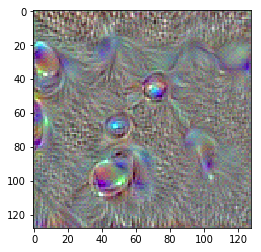

In [20]:
fig1 = plt.imshow(img)
# show the plot
plt.show()